In [2]:
from IPython.display import Image

## **Timeseries RNN(LSTM)**
- 개인 tistory url: https://eunhye-zz.tistory.com/8

이 장에서는 Multiple column을 갖는 Timeseries 형태의 데이터를 예측하는 모델을 만들며  LSTM을 사용한 모델링 과정을 서술한다. 직전 데이터 N개의 정보를 활용하여 이후 1개 시점을 예측하는 Many to one 방법을 사용하였다. 예시로 사용하는 데이터는 구글 주식 데이터로  1주 전(1~7) 데이터를 가지고 8일째 가격을 예측하는 모델을 만들 것이다. 

## **1.Data**
주식을 예측하기 위해 사용할 수 있는 데이터는 시가, 종가 등 5개의 컬럼이며 이를 **Input dimension**이라고 부른다.

이전 7일의 정보를 활용하여 그 다음 종가를 예측하므로 **Sequence = 7, Output dimension = 1**이다. 

<img src = "https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbZ53w5%2FbtrvYuJmMJx%2FdPfdt7i06jRoVRJKXfzPj1%2Fimg.png" width="50%" height="100%">


## **2.LSTM**
바닐라 RNN은 비교적 짧은 시퀀스에 대해서만 효과를 보이는 단점이 있어 뒤로 갈수록 맨 처음의 정보량은 손실되고 영향력은 거의 의미가 없을 수도 있게 된다. 

<img src = "https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fd4qAxu%2Fbtrv0P7C2wG%2FoReTrR3wmDcuL5fgYZi72k%2Fimg.png" width="50%" height="100%">


RNN으로 만든 언어 모델이 다음 단어를 예측하는 과정을 생각해보자. 예를 들어 "모스크바에 여행을 왔는데 건물도 예브고 먹을 것도 맛있었어. 그런데 글쎄 직장 상사한테 전화가 왔어. 어디냐고 묻더라구 그래서 나는 말했지. 저 여행왔는데요. 여기____" 다음 단어를 예측하기 위해서는 장소 정보가 필요하다. 그런데 장소 정보에 해당되는 단어인 '모스크바'는 앞에 위치하고 있고, RNN이 충분한 기억력을 가지고 있지 못한다면 다음 단어를 엉뚱하게 예측한다. 이를 **장기 의존성 문제**라고 한다. 

전통적인 RNN의 이러한 단점을 보완한 RNN의 일종을 **장단기 메모리(Long Short-Term Memory)**라고 하며, 줄여서 LSTM이라고 한다. LSTM은 은닉 상태(hidden state)를 계산하는 식이 바닐라 RNN보다 조금 더 복잡해졌으며 셀 상태(cell state)라는 값을 추가한다. 

LSTM를 활용한 모델 생성 코드는 아래와 같다.

## **3.Time Series Forecasting model**
### **3-1) Data Preprocessing**
##### *3-1-1) 학습/테스트 데이터 분할*

In [4]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 데이터 불러오기
df = pd.read_csv('./pytorch_template_data/data-02-stock_daily.csv')

# 7일간의 데이터가 입력으로 들어가고 batch size는 임의로 지정
seq_length = 7
batch = 100

# 데이터를 역순으로 정렬하여 전체 데이터의 70% 학습, 30% 테스트에 사용
df = df[::-1]
train_size = int(len(df)*0.7)
train_set = df[0:train_size]
test_set = df[train_size-seq_length:]


##### *3-1-2) 데이터 스케일링*
 사용되는 설명변수들의 크기가 서로 다르므로 각 컬럼을 0-1 사이의 값으로 스케일링 한다. 

In [6]:
# Input scale
scaler_x = MinMaxScaler()
scaler_x.fit(train_set.iloc[:, :-1])

train_set.iloc[:, :-1] = scaler_x.transform(train_set.iloc[:, :-1])
test_set.iloc[:, :-1] = scaler_x.transform(test_set.iloc[:, :-1])

# Output scale
scaler_y = MinMaxScaler()
scaler_y.fit(train_set.iloc[:, [-1]])

train_set.iloc[:, -1] = scaler_y.transform(train_set.iloc[:, [-1]])
test_set.iloc[:, -1] = scaler_y.transform(test_set.iloc[:, [-1]])


C:\Users\USER\Anaconda3\envs\kodaco\lib\site-packages\pandas\core\indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
C:\Users\USER\Anaconda3\envs\kodaco\lib\site-packages\pandas\core\indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
C:\Users\USER\Anaconda3\envs\kodaco\lib\site-packages\pandas\core\indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

##### *3-1-3) 데이터셋 생성 및 tensor 형태로 변환*

**파이토치에서는 3D 텐서의 입력을 받으므로 torch.FloatTensor를 사용하여 np.arrary 형태에서 tensor 형태로 바꿔준다.** 파이토치에서는 데이터를 좀 더 쉽게 다룰 수 있도록 유용한 도구로서 데이터셋(Dataset)과 데이터로더(DataLoader)를 제공하는데 이를 사용하면 미니 배치 학습, 데이터 셔플, 병렬 처리 등 간단히 수행할 수 있다. 기본적인 사용 방법은 Dataset을 정의하고 이를 DataLoader에 전달하는 것이다.  

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

# 데이터셋 생성 함수
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series)-seq_length):
        _x = time_series[i:i+seq_length, :]
        _y = time_series[i+seq_length, [-1]]
        # print(_x, "-->",_y)
        dataX.append(_x)
        dataY.append(_y)

    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(np.array(train_set), seq_length)
testX, testY = build_dataset(np.array(test_set), seq_length)

# 텐서로 변환
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

# 텐서 형태로 데이터 정의
dataset = TensorDataset(trainX_tensor, trainY_tensor)

# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
dataloader = DataLoader(dataset,
                        batch_size=batch,
                        shuffle=True,  
                        drop_last=True)

### **3-2) LSTM**
입력 컬럼은 5개, output 형태는 1개이며 hidden_state는 10개, 학습률은 0.01 등 임의 지정하였다. LSTM 구조를 정의한 Net 클래스에서는 **__init__** 생성자를 통해 layer를 초기화하고 **forward** 함수를 통해 실행한다. **reset_hidden_state** 은 학습시 seq별로 hidden state를 초기화 하는 함수로 학습시 이전 seq의 영향을 받지 않게 하기 위함이다. 

In [9]:
# 설정값
data_dim = 5
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
nb_epochs = 100


class Net(nn.Module):
    # # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layers,
                            # dropout = 0.1,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias=True)

    # 학습 초기화를 위한 함수
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.layers, self.seq_len, self.hidden_dim),
            torch.zeros(self.layers, self.seq_len, self.hidden_dim))

    # 예측을 위한 함수
    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.fc(x[:, -1])
        return x


### **3-3) Training**

데이터셋과 알고리즘의 구조를 정의하였다면 실제로 학습이 수행될 함수를 정의한다. **verbose**는 epoch를 해당 verbose번째 마다 출력하기 위함이고, **patience**는 train loss를 patience만큼 이전 손실값과 비교해 줄어들지 않으면 학습을 종료시킬 때 사용한다. 

학습 과정을 직관적으로 살펴보기 위해 dataloader에 저장되어 있는 데이터를 한 배치씩 for문으로 학습하고 loss를 계산 후 verbose 마다 loss를 출력한다. 

**early stopping**으로 epoch의 횟수는 늘어나지만 학습의 효과가 보이지 않으면 중단하는 코드를 추가하였다.

마지막으로 출력에서는 **model.eval()**을 사용하였는데 evaluation 과정에서 사용되지 말아야할 layer들을 알아서 꺼주는 함수다. 

In [10]:
def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):
     
    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    nb_epochs = num_epochs
    
    # epoch마다 loss 저장
    train_hist = np.zeros(nb_epochs)

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)
        
        for batch_idx, samples in enumerate(train_df):

            x_train, y_train = samples
            
            # seq별 hidden state reset
            model.reset_hidden_state()
            
            # H(x) 계산
            outputs = model(x_train)
                
            # cost 계산
            loss = criterion(outputs, y_train)                    
            
            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            avg_cost += loss/total_batch
               
        train_hist[epoch] = avg_cost        
        
        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))
            
        # patience번째 마다 early stopping 여부 확인
        if (epoch % patience == 0) & (epoch != 0):
            
            # loss가 커졌다면 early stop
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Early Stopping')
                
                break
            
    return model.eval(), train_hist

 다음 기기로 학습합니다. :  cpu
Epoch: 0000 train loss : 0.5254
Epoch: 0020 train loss : 0.0043
Epoch: 0040 train loss : 0.0018
Epoch: 0060 train loss : 0.0016

 Early Stopping


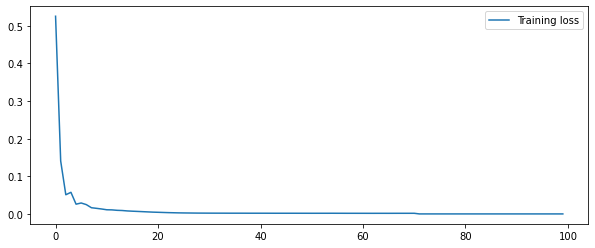

In [13]:
USE_CUDA = torch.cuda.is_available()  # GPU를 사용가능하면 True, 아니라면 False 리턴
# GPU 사용 가능하면 사용하고 아니면 CPU 사용
device = torch.device("cuda" if USE_CUDA else "cpu")
print(" 다음 기기로 학습합니다. : ", device)

# 랜덤 시드 고정
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)
    
# 모델 학습
net = Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)
model, train_hist = train_model(
    net, dataloader, num_epochs=nb_epochs, lr=learning_rate, verbose=20, patience=10)


# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

### **3-4) Model Save & Load**

pythorch는 .pt 또는 .pth 파일 확장자로 모델을 저장한다. 추론을 위해 모델을 저장할 때는 학습된 모델의 매개변수만 저장하면 되는데 torch 사용하여 모델의 state_dict을 저장하는 것이 나중에 모델을 사용할 때 가장 유연하게 사용할 수 있는 모델 저장시 권장하는 방법이라고 한다. 

또한 모델을 불러 온 후에는 반드시 model.eval() 를 호출하여 드롭아웃 및 배치 정규화를 평가모드로 설정하도록 한다. **평가모드를 사용하지 않고 테스트를 하게 되면 추론 결과가 일관성없게 추론된다.** 

In [ ]:
# 모델 저장
PATH = "./Timeseries_LSTM_data-02-stock_daily_.pth"
torch.save(model.state_dict(), PATH)

# 불러오기
model = Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)
model.load_state_dict(torch.load(PATH), strict=False)
model.eval()


### **3-5) Evaluation**

마지막으로 테스트 데이터셋에 대한 검증을 한다. torch.no_grad() 함수를 사용하면 gradient 계산을 수행하지 않게 되어 메모리 사용량을 아껴준다고 한다. 
**또한 예측시에도 새로운 seq가 입력될 때마다 hidden_state를 초기화해야 이전 seq의 영향을 받지 않는다고 한다.**

MAE SCORE :  11.382053711861005


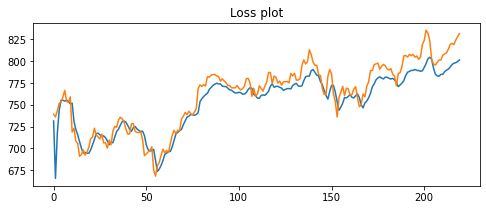

In [17]:
# 예측 테스트
with torch.no_grad():
    pred = []
    for pr in range(len(testX_tensor)):

        model.reset_hidden_state()

        predicted = model(torch.unsqueeze(testX_tensor[pr], 0))
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)

    # INVERSE
    pred_inverse = scaler_y.inverse_transform(np.array(pred).reshape(-1, 1))
    testY_inverse = scaler_y.inverse_transform(testY_tensor)


def MAE(true, pred):
    return np.mean(np.abs(true-pred))


print('MAE SCORE : ', MAE(pred_inverse, testY_inverse))


fig = plt.figure(figsize=(8,3))
plt.plot(np.arange(len(pred_inverse)), pred_inverse, label = 'pred')
plt.plot(np.arange(len(testY_inverse)), testY_inverse, label = 'true')
plt.title("Loss plot")
plt.show()
